In [40]:
!pip install wordcloud -q > /dev/null 2>&1
!pip install spacy -q > /dev/null 2>&1
!python -m spacy download fr_core_news_sm > /dev/null 2>&1

print("------------Packages downloaded-----------")


------------Packages downloaded-----------


In [41]:
import spacy
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_distances
from wordcloud import WordCloud
from collections import Counter
from scipy.spatial.distance import pdist, squareform, cdist
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# 1. Cleaning data and preprocessing

Based on the results of the descriptive statistics, we construct a dataframe containing the document identifier, the year, the political party (identified by the variable "titulaire-soutien"), as well as the content of the manifesto. We retain only those manifestos for which a supporting political party is explicitly identified. Furthermore, in order to ensure class representativeness, we exclude political parties associated with fewer than 30 manifestos.

In [42]:
from create_dataframe import prepare_legislatives_dataset

csv_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981.csv"
txt_p = "/home/onyxia/work/NLP_rendus/.ipynb_checkpoints/data/legislatives_1981"

df_final = prepare_legislatives_dataset(csv_p, txt_p)

print("------------Df created-----------")

------------Df created-----------


Before implementing logistic regression, we will do:
1. **OCR artifact cleaning:** remove line breaks, special characters, and isolated small numbers.
2. **Text normalization:** convert text to lowercase, remove unnecessary punctuation.
3. **Tokenization and filtering:** remove stopwords, punctuation, and whitespace tokens.
4. **Lemmatization:** reduce words to their base form.
5. **Filter rare words**

These operations reduce noise, standardize the text, and retain only meaningful lexical information, thereby improving the robustness and interpretability of subsequent NLP models.

In [43]:
from functions_to_clean_data import preprocess_text, filter_rare_words 

# Execution
print("Starting text cleaning with spaCy (this may take 1–2 minutes)...")
df_final["clean_text"] = df_final["text_content"].apply(preprocess_text)
df_final["clean_text_filtered"] = filter_rare_words(df_final["clean_text"], min_docs=5)
print("Text cleaning completed")


Starting text cleaning with spaCy (this may take 1–2 minutes)...
Text cleaning completed


## 1.2 Wordclouds for each category

We begin by generating word clouds for each category in order to obtain an initial qualitative insight into the existence of a “signature” vocabulary for each party, as well as a preliminary mapping of parties that display similar lexical patterns.

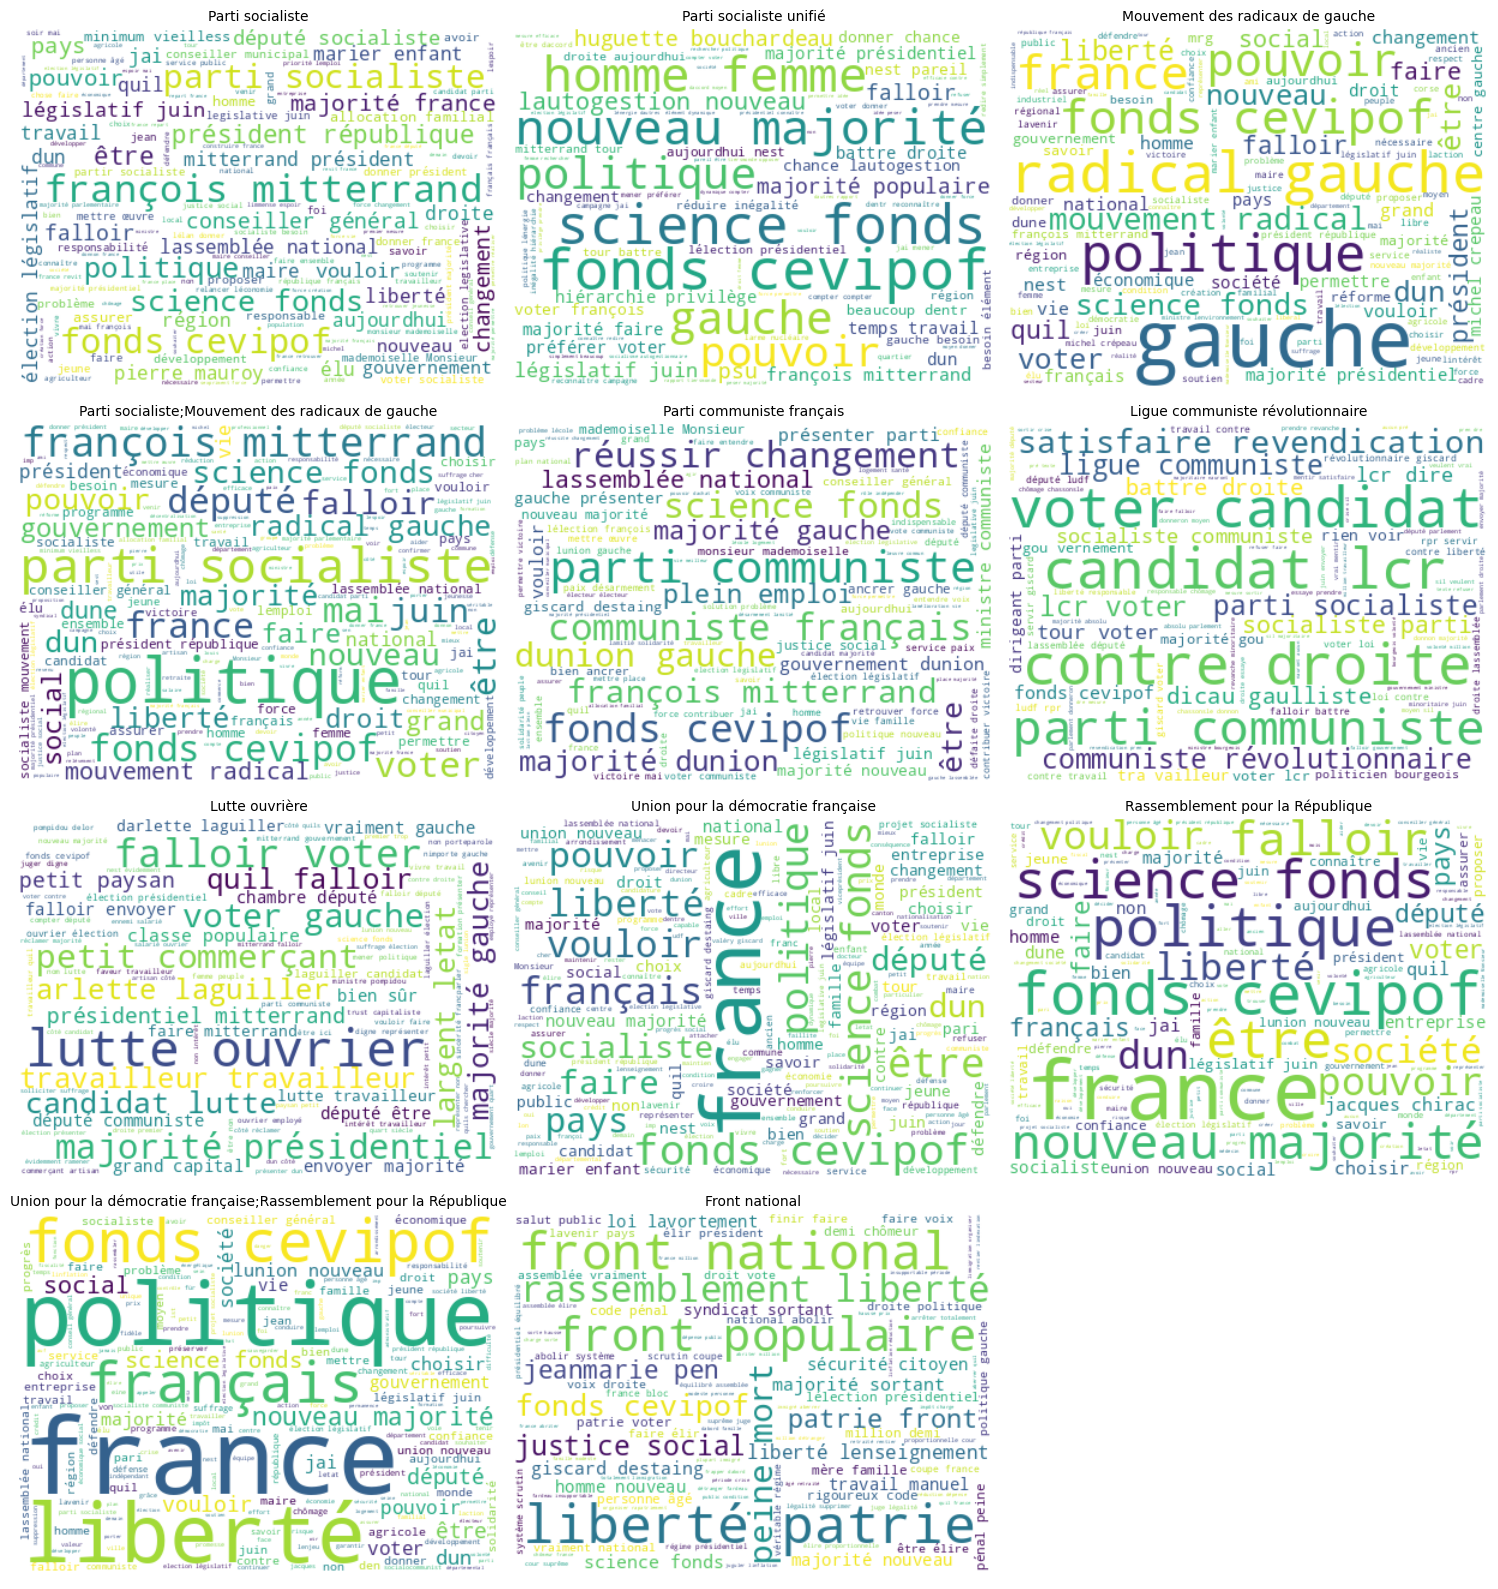

In [12]:
########################### Worldclouds for each category #############################

# List of categories in a specific order
categories = [
    "Parti socialiste", "Parti socialiste unifié",
    "Mouvement des radicaux de gauche", "Parti socialiste;Mouvement des radicaux de gauche",
    "Parti communiste français", "Ligue communiste révolutionnaire", "Lutte ouvrière",
    "Union pour la démocratie française", "Rassemblement pour la République",
    "Union pour la démocratie française;Rassemblement pour la République", "Front national"
]

## Create a figure with subplots

# Number of columns for display and automatically computation of the number of rows
n_cols = 3
n_rows = (len(categories) + n_cols - 1) // n_cols  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  

# Loop over categories to generate WordClouds
for i, cat in enumerate(categories):
    # Merge all preprocessed texts for the current category
    text_cat = " ".join(df_final[df_final['titulaire-soutien'] == cat]['clean_text_filtered'].astype(str))
    
    if text_cat.strip():  
        # Generate Wordcloud
        wc = WordCloud(
            width=400,
            height=300,
            background_color='white',
            colormap='viridis'
        ).generate(text_cat)
        
        # Display the WordCloud in the subplot
        axes[i].imshow(wc, interpolation='bilinear')
        axes[i].axis('off')
        axes[i].set_title(cat, fontsize=10)
    else:
        axes[i].axis('off')
        axes[i].set_title(f"{cat} (no data)", fontsize=10)


# Remove unused axes if the number of categories is not a multiple of n_cols
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


# 2. Regression logistic's implementation (first test without fusioning or deleting categories)

As we have some categories with a small number of manifestos, we will use stratified cross-validation and hyperparameter tuning. Futhermore, since the categories are imbalanced, our goal is to  maximize F1 score and we will use `class_weight='balanced'` to give more importance to minority classes.

Fitting 5 folds for each of 18 candidates, totalling 90 fits


=== BEST PIPELINE ===


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


"✅ Best hyperparameters: {'lr__C': 1.0, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.9017"


--- CLASSIFICATION REPORT (CV) ---
                                                                     precision    recall  f1-score   support

                                                     Front national       1.00      0.98      0.99        44
                                   Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                                                     Lutte ouvrière       1.00      0.99      1.00       159
                                   Mouvement des radicaux de gauche       0.98      0.87      0.92        46
                                          Parti communiste français       1.00      1.00      1.00       463
                                                   Parti socialiste       0.95      0.98      0.97       407
                                            Parti socialiste unifié       1.00      0.99      0.99       148
                  Parti socialiste;Mouvement des radicaux de gauche       0.68      0.50   

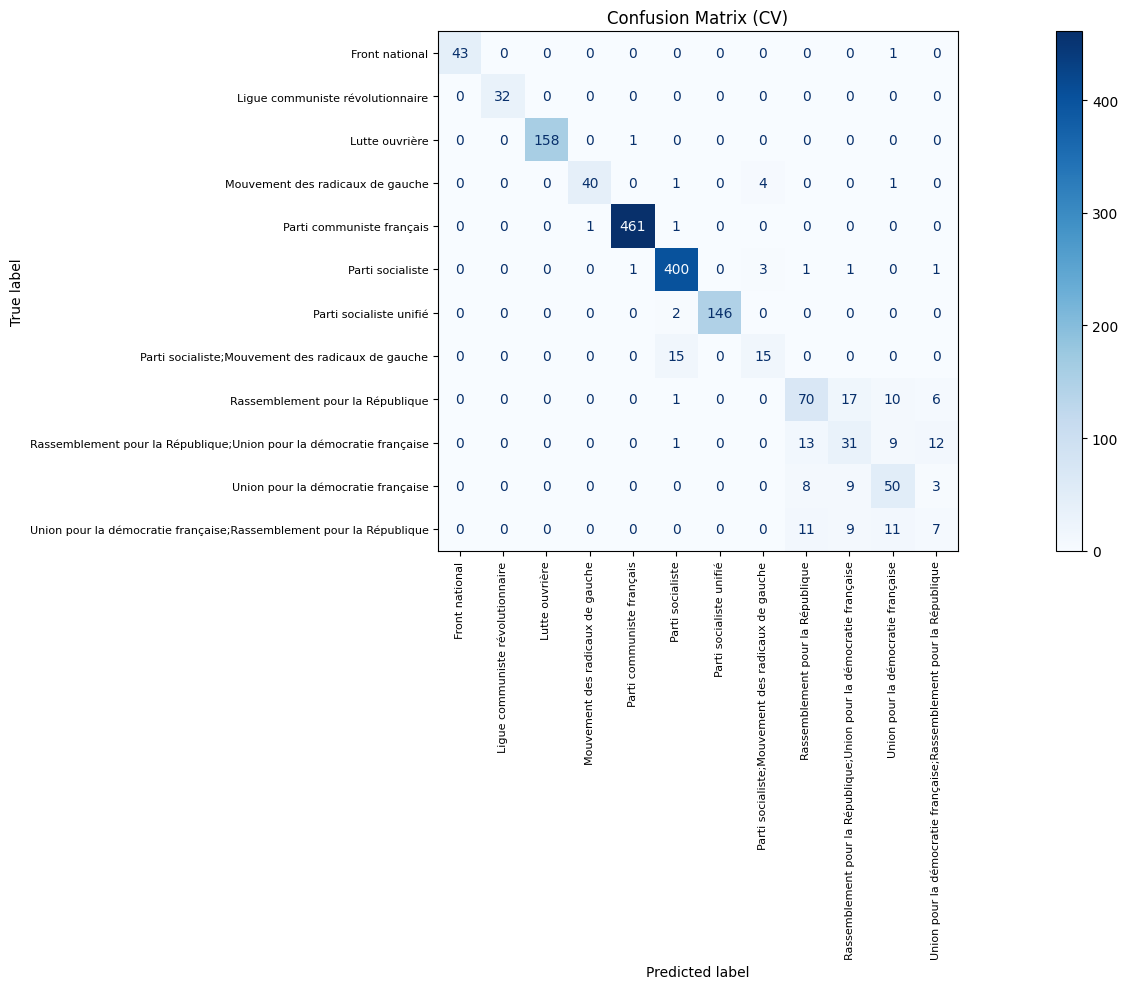

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


In [13]:
from regression_logistique import logistic_regression_nlp

######################"""" Implementation of the logistic regression (with bi-categories) #########################
logistic_regression_nlp(df_final, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

As we had anticipated from the word clouds, the classification of manifestos with dual support performs poorly (F1-score ranging from 0.18 to 0.59). We therefore choose to implement a second logistic regression by excluding these categories, in order to minimize noise and confusion.

# 3. Logistic regression (after deleting the bi-support categories)

## 3.1 Model implementation

Fitting 5 folds for each of 18 candidates, totalling 90 fits


=== BEST PIPELINE ===


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('tfidf', ...), ('lr', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"input input: {'filename', 'file', 'content'}, default='content'- If `'filename'`, the sequence passed as an argument to fit is expected to be a list of filenames that need reading to fetch the raw content to analyze.- If `'file'`, the sequence items must have a 'read' method (file-like object) that is called to fetch the bytes in memory.- If `'content'`, the input is expected to be a sequence of items that can be of type string or byte.",'content'
,"encoding encoding: str, default='utf-8'If bytes or files are given to analyze, this encoding is used todecode.",'utf-8'
,"decode_error decode_error: {'strict', 'ignore', 'replace'}, default='strict'Instruction on what to do if a byte sequence is given to analyze thatcontains characters not of the given `encoding`. By default, it is'strict', meaning that a UnicodeDecodeError will be raised. Othervalues are 'ignore' and 'replace'.",'strict'
,"strip_accents strip_accents: {'ascii', 'unicode'} or callable, default=NoneRemove accents and perform other character normalizationduring the preprocessing step.'ascii' is a fast method that only works on characters that havea direct ASCII mapping.'unicode' is a slightly slower method that works on any characters.None (default) means no character normalization is performed.Both 'ascii' and 'unicode' use NFKD normalization from:func:`unicodedata.normalize`.",None
,"lowercase lowercase: bool, default=TrueConvert all characters to lowercase before tokenizing.",True
,"preprocessor preprocessor: callable, default=NoneOverride the preprocessing (string transformation) stage whilepreserving the tokenizing and n-grams generation steps.Only applies if ``analyzer`` is not callable.",None
,"tokenizer tokenizer: callable, default=NoneOverride the string tokenization step while preserving thepreprocessing and n-grams generation steps.Only applies if ``analyzer == 'word'``.",None


"✅ Best hyperparameters: {'lr__C': 0.1, 'tfidf__max_features': 3000, 'tfidf__ngram_range': (1, 2)}, F1 (CV): 0.9738"


--- CLASSIFICATION REPORT (CV) ---
                                    precision    recall  f1-score   support

                    Front national       1.00      0.98      0.99        44
  Ligue communiste révolutionnaire       1.00      1.00      1.00        32
                    Lutte ouvrière       1.00      1.00      1.00       159
  Mouvement des radicaux de gauche       0.98      0.96      0.97        46
         Parti communiste français       1.00      1.00      1.00       463
                  Parti socialiste       0.99      0.99      0.99       407
           Parti socialiste unifié       1.00      0.99      0.99       148
  Rassemblement pour la République       0.85      0.85      0.85       104
Union pour la démocratie française       0.77      0.81      0.79        70

                          accuracy                           0.97      1473
                         macro avg       0.95      0.95      0.95      1473
                      weighted avg       0.97     

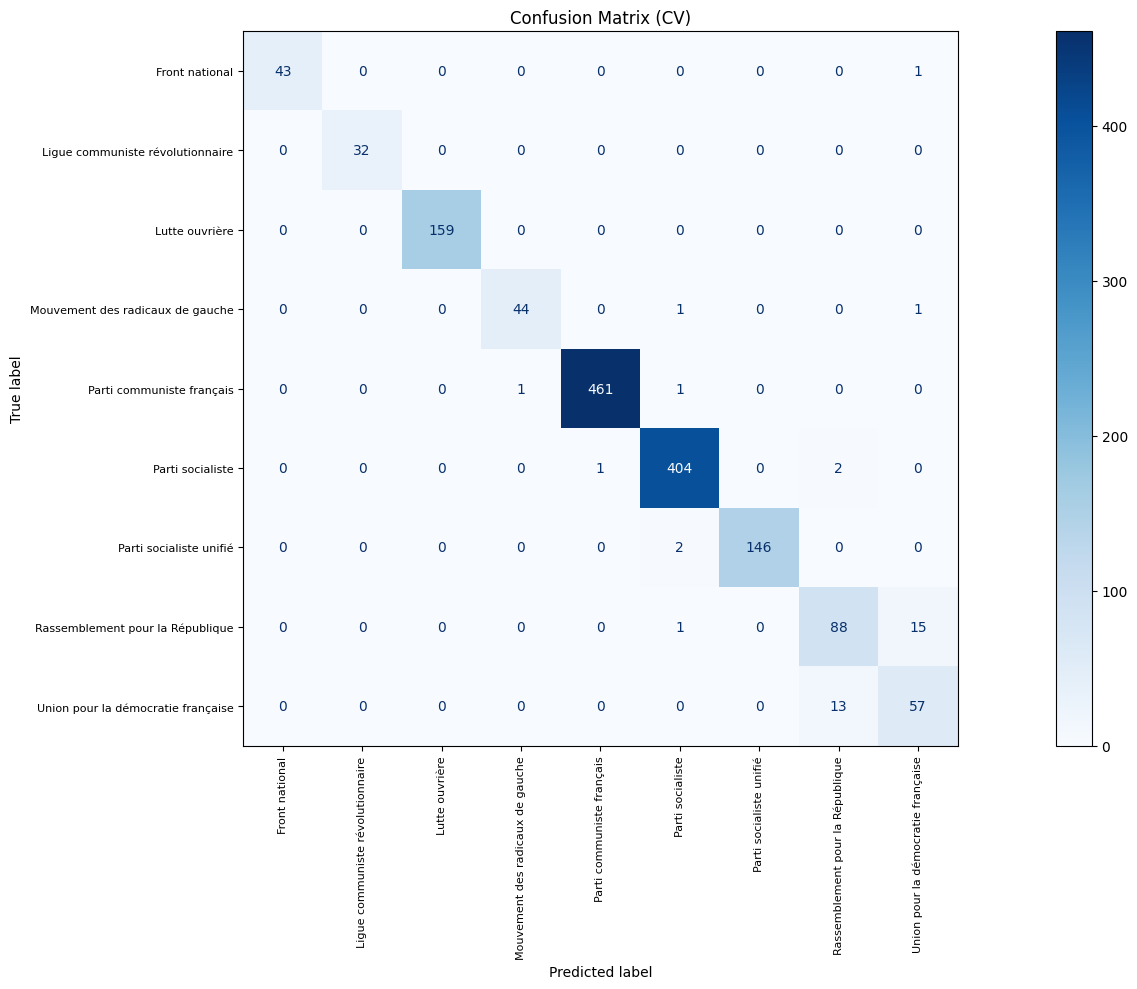

In [44]:
from regression_logistique import logistic_regression_nlp

# Deleting the bi-support categories
categories_a_supprimer = ['Parti socialiste;Mouvement des radicaux de gauche', 'Rassemblement pour la République;Union pour la démocratie française',  'Union pour la démocratie française;Rassemblement pour la République']
df_final_sans_cat_mixte = df_final[~df_final['titulaire-soutien'].isin(categories_a_supprimer)]

# Implementation of the logistic regression
best_model =logistic_regression_nlp(df_final_sans_cat_mixte, text_col="clean_text_filtered", label_col="titulaire-soutien", min_docs=5,  cv_folds=5, random_state=42)

This second regression yields good classification (macro f1-score de 0,95) results and will serve as our baseline.

In [45]:

from regression_logistique import extract_model_assets

# Extract essential components of logistic regression
assets = extract_model_assets(best_model)

## 3.2 Coefficients' interpretation

We will now identify the words that are most discriminative for the classification performed by the logistic regression.
For better readability, positive coefficients will be displayed in blue and negative coefficients in red.

In [46]:
############### formatted tables of the most discriminant words  #########################

from regression_logistique import build_coef_df, display_three_parties_abs, extract_model_assets

# Build tidy coefficient DataFrame
coef_df = build_coef_df(assets)

# Categories / parties
categories = list(assets['classes'])

# Display top features
display_three_parties_abs(coef_df, categories)


/home/onyxia/work/NLP_rendus/regression_logistique.py:141: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols).format(precision=3)


,Front national - mot,Front national - coef,Ligue communiste révolutionnaire - mot,Ligue communiste révolutionnaire - coef,Lutte ouvrière - mot,Lutte ouvrière - coef
0,front,1.244,lcr,1.136,lutte ouvrier,0.810
1,patrie,1.062,candidat lcr,0.749,ouvrier,0.707
2,front national,0.873,lunité,0.740,lutte,0.662
3,liberté patrie,0.802,patron,0.668,travailleur,0.602
4,rassemblement,0.591,contre,0.577,laguiller,0.493
5,national,0.576,droite,0.532,mitterrand,0.429
6,rassemblement liberté,0.566,voie,0.522,falloir voter,0.413
7,pen,0.508,satisfaire revendication,0.521,chambre,0.407
8,jeanmarie pen,0.506,revendication,0.509,trop,0.404
9,liberté,0.476,voter candidat,0.501,gauche,0.365


/home/onyxia/work/NLP_rendus/regression_logistique.py:141: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols).format(precision=3)


,Mouvement des radicaux de gauche - mot,Mouvement des radicaux de gauche - coef,Parti communiste français - mot,Parti communiste français - coef,Parti socialiste - mot,Parti socialiste - coef
0,radical,1.628,communiste,1.386,socialiste,0.878
1,radical gauche,1.617,dunion,0.658,parti socialiste,0.678
2,mouvement radical,1.131,réussir,0.648,président,0.533
3,gauche,0.948,gauche,0.583,françois mitterrand,0.526
4,michel,0.686,changement,0.546,gauche,-0.526
5,mouvement,0.589,communiste français,0.517,communiste,-0.517
6,communiste,-0.412,parti communiste,0.494,françois,0.496
7,réaliste,0.373,réussir changement,0.488,france,0.449
8,centre,0.357,dunion gauche,0.432,majorité france,0.405
9,travailleur,-0.286,victoire,0.411,mitterrand,0.395


/home/onyxia/work/NLP_rendus/regression_logistique.py:141: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  styled = combined.style.applymap(color_coef, subset=coef_cols).format(precision=3)


,Parti socialiste unifié - mot,Parti socialiste unifié - coef,Rassemblement pour la République - mot,Rassemblement pour la République - coef,Union pour la démocratie française - mot,Union pour la démocratie française - coef
0,psu,0.960,jacques chirac,0.738,gauche,-0.609
1,nucléaire,0.758,jacques,0.592,union,0.488
2,lautogestion,0.733,gauche,-0.559,union nouveau,0.414
3,autogestionnaire,0.526,société,0.458,excès,0.385
4,populaire,0.493,chirac,0.432,enfant,0.335
5,femme,0.431,union nouveau,0.357,démocrate,0.318
6,alternative,0.423,radical,-0.354,france,0.314
7,majorité populaire,0.409,liberté,0.340,radical gauche,-0.300
8,bouchardeau,0.408,nouveau majorité,0.314,droite,-0.294
9,hiérarchie,0.405,oui,0.309,falloir,-0.279


# 4. Projection et indice de dissimilarité

## 4.1 Projection in 2D




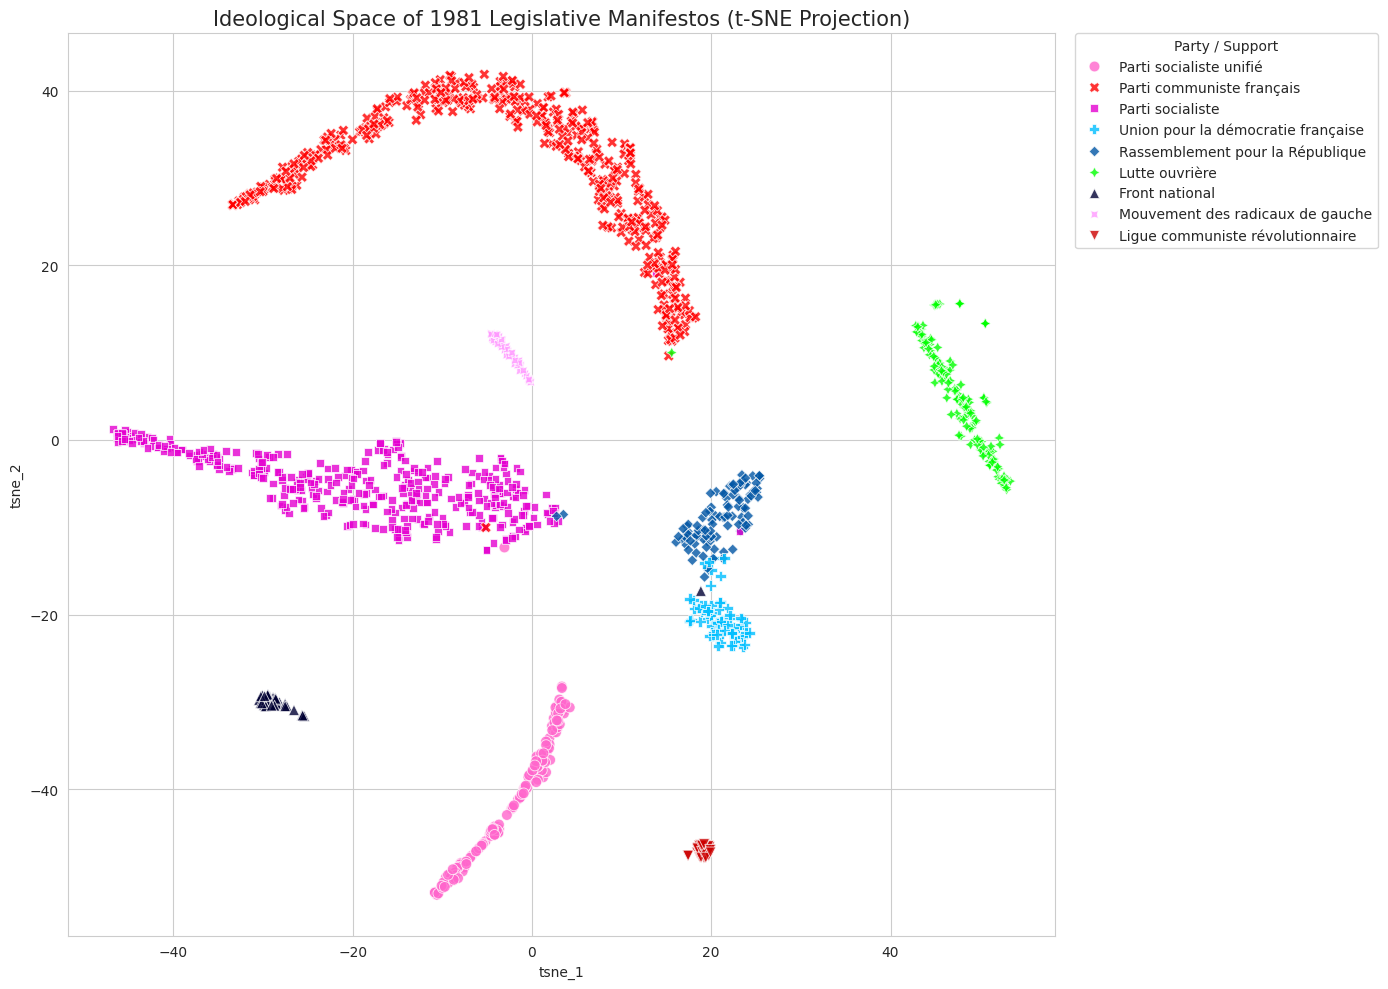

In [48]:
############################""  Visualizing the ideological space of the manifestos using 2D projection (t-SNE or UMAP)###################

from regression_logistique import build_master_df

# Build df with t-SNE 
df_final_sans_cat_mixte, X = build_master_df(
    df=df_final_sans_cat_mixte,              
    assets=assets,
    text_col="clean_text_filtered",    
    label_col="titulaire-soutien"     
)

# Color palette
custom_palette = {
    'Parti socialiste': '#E400D0',               # Pink
    'Parti socialiste unifié': '#FF66CC',        # Light Pink
    'Mouvement des radicaux de gauche': '#FF99FF', # Very light pink / lavender
    'Rassemblement pour la République': '#0055A4',  # Dark Blue
    'Union pour la démocratie française': '#00BFFF', # Light Blue
    'Parti communiste français': '#FF0000',     # Red
    'Ligue communiste révolutionnaire': '#CC0000', # Dark Red
    'Lutte ouvrière': '#00FF00',                # Green
    'Front national': '#000033',                # Dark Navy
    'Ecologiste': '#33CC33',                     # Dark Green
}


#  Scatterplot with improved visuals
plt.figure(figsize=(14, 10))
sns.set_style("whitegrid")  # Clean background for readability

plot = sns.scatterplot(
    data=df_final_sans_cat_mixte, 
    x='tsne_1',           # First 2D coordinate from projection
    y='tsne_2',           # Second 2D coordinate from projection
    hue='titulaire-soutien', 
    palette=custom_palette,  # Use custom colors
    style='titulaire-soutien',  # Different shapes per party for clarity
    alpha=0.8, 
    edgecolor='w', 
    s=60  # Point size
)

# Final touches
plt.title("Ideological Space of 1981 Legislative Manifestos (t-SNE Projection)", fontsize=15)
plt.legend(
    bbox_to_anchor=(1.02, 1), 
    loc='upper left', 
    borderaxespad=0, 
    title="Party / Support"
)
plt.tight_layout()
plt.show()


## 4.2 Indice de dissimiliraté entre les partis
Using coefficients from the logistic regression, we compute a semantic dissimilarity index between parties.
This index highlights which parties are semantically closest (similar) and which are most distant.
Diagonal: intra-party cohesion (1 - mean cosine similarity of texts within the party)
Off-diagonal: inter-party distance (cosine distance between party vectors= 1 -similarity between party vectors)

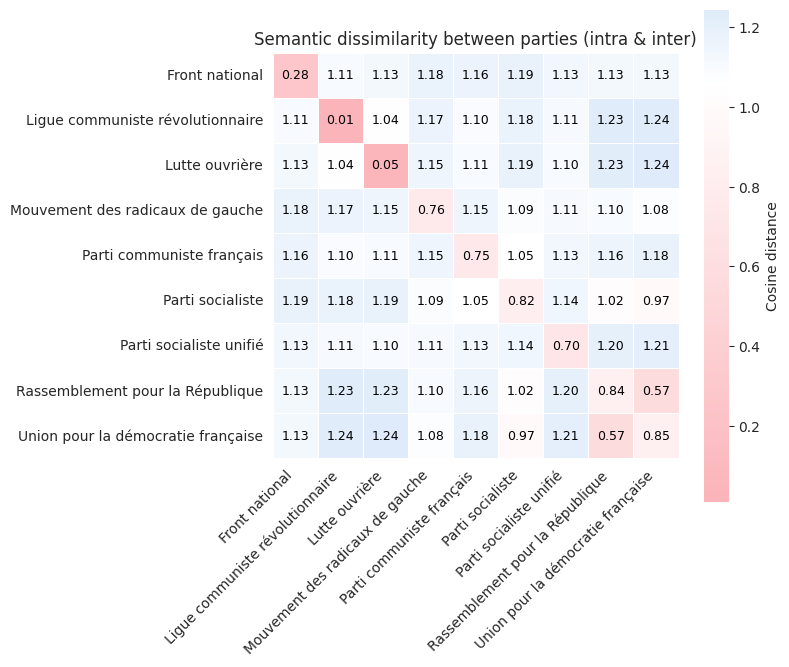

In [49]:
############ Compute and plot semantic dissimilarity between parties (combining inter-party distances and intra-party cohesion) ##################

from regression_logistique import transform_texts, compute_centroid_distances, compute_intra_party_distances

X = transform_texts(
    df_final,
    assets["vectorizer"],
    "clean_text_filtered"
).toarray()

df_final = compute_centroid_distances(
    df_final,
    X,
    assets["classes"],
    "titulaire-soutien"
)

parties = assets["classes"]

# Compute intra-party cohesion
intra_distances = compute_intra_party_distances(
    df_final,
    X,
    label_col="titulaire-soutien"
)

dist_df_cos = pd.DataFrame(
    cosine_distances(assets["coefs"]),
    index=assets["classes"],
    columns=assets["classes"]
)

# Copy for plotting
dist_plot = dist_df_cos.copy()

# Replace diagonal with intra-party distances
for p in parties:
    if p in dist_plot.index:
        dist_plot.loc[p, p] = intra_distances[p]

#  Plot the heatmap 
plt.figure(figsize=(8, 7))

# Define a soft pastel gradient: pale pink -> white -> light blue
colors = ["#fbb4b9", "white", "#4a90e2"]  
cmap = LinearSegmentedColormap.from_list("pastel_gradient", colors)

sns.heatmap(
    dist_plot,
    annot=True,               # Show numeric values
    fmt=".2f",
    cmap=cmap,
    center=dist_plot.mean().mean(),  # Center colormap on mean
    linewidths=0.5,
    cbar_kws={'label': 'Cosine distance'},
    square=True,
    annot_kws={"color": "black", "fontsize": 9}  # Annotation style
)

plt.title("Semantic dissimilarity between parties (intra & inter)")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## 5. Outlier Detection Framework

To robustly identify and analyze atypical manifestos, we implement three complementary methods.  
Each method captures a different dimension of outlier behavior: structural deviation, local semantic inconsistency, and model-based conflict.

| Method | What It Detects | 
|--------|------------------|
| **Distance to Centroid** | Stylistic or thematic originality within a party | 
| **K-NN (t-SNE space)** | Immediate semantic neighborhood anomalies |
| **Logistic Probability** | Conflict with the decision boundary of the classifier ( model-level inconsistencies) |

By combining these three approaches, we aim to compare global structure (centroid), local structure (K-NN), and decision-based structure (logit).


## 5.1 Identify outliers by distance to the centroïd : a study of global structure

In [60]:
from outliers_reg_logistique import detect_centroid_outliers

# Identify outliers by distance to the centroid (using the IQR rule)
df_final_sans_cat_mixte, df_centroid_outliers = detect_centroid_outliers(df_final_sans_cat_mixte, best_model)

In [65]:
## Proportion of misclassification among outliers per party

from outliers_reg_logistique import display_centroid_outliers_report

sstats_centroid = display_centroid_outliers_report(
    df_full=df_final_sans_cat_mixte, 
    df_outliers=df_centroid_outliers, 
    model=best_model,                
    text_col='clean_text_filtered',  
    label_col='titulaire-soutien',
    method_name="Centroid")


=== Proportion of Centroid outliers' misclassification per category ===


,total_outliers,nb_mal_classes,proportion_misclassification_%
titulaire-soutien,,,
Lutte ouvrière,26,0,0.00
Parti communiste français,13,2,15.38
Front national,10,0,0.00
Ligue communiste révolutionnaire,2,0,0.00
Parti socialiste,2,0,0.00


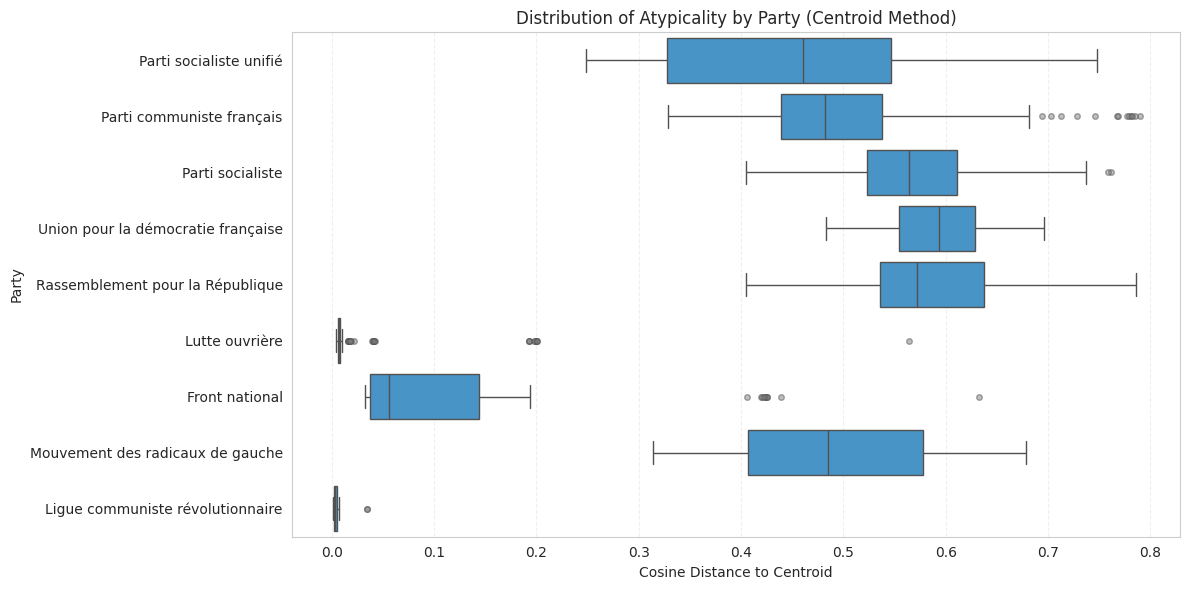

In [72]:
# Visualization: Boxplot of outliers
plt.figure(figsize=(12, 6))
sns.boxplot(
    data=df_final_sans_cat_mixte, 
    x='distance_au_centre', 
    y='titulaire-soutien', 
    color='#3498db', # Professional blue
    flierprops={"marker": "o", "markersize": 4, "markerfacecolor": "gray", "alpha": 0.5} 
)
    
plt.xlabel("Cosine Distance to Centroid")
plt.ylabel("Party")
plt.title("Distribution of Atypicality by Party (Centroid Method)")
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

In [140]:
from outliers_reg_logistique import rapport_outliers_style
from regression_logistique import extract_model_assets

# Extract model assets
assets = extract_model_assets(best_model)
feature_names = assets['feature_names']
classes = assets['classes']

# Select top 15 outliers by centroid distance
target_centroid = df_centroid_outliers.nlargest(15, 'distance_au_centre')

# Transform texts into TF-IDF
X_centroid = best_model.named_steps['tfidf'].transform(target_centroid['clean_text_filtered']).toarray()

# Display analysis
print("=== ANALYSIS OF OUTLIERS: CENTROID DISTANCE ===")
display(rapport_outliers_style(target_centroid, X_centroid, best_model, feature_names, classes))


=== ANALYSIS OF OUTLIERS: CENTROID DISTANCE ===


,ID,Vrai Parti,Prédit,Challenger (2nd),Mots Ancres (Confirmant),Mots Transfuges (Vers Challenger),Statut
0,EL136_L_1981_06_067_03_1_PF_02,Parti communiste français (20.5%),Parti communiste français,Parti socialiste (15.2%),"communiste, sie, ich, changement, das","ensemble, sie, werden, mai, wir",✅ Atopique
1,EL136_L_1981_06_067_07_1_PF_01,Parti communiste français (23.1%),Parti communiste français,Rassemblement pour la République (14.3%),"communiste, sie, réussir, das, contribuer","vouloir, liberté, für, monsieur, lunion",✅ Atopique
2,EL136_L_1981_06_067_08_1_PF_02,Parti communiste français (23.3%),Parti communiste français,Rassemblement pour la République (14.4%),"communiste, sie, réussir, das, contribuer","vouloir, monsieur, liberté, für, lunion",✅ Atopique
3,EL136_L_1981_06_067_01_1_PF_01,Parti communiste français (22.0%),Parti communiste français,Rassemblement pour la République (14.5%),"communiste, sie, réussir, das, contribuer","für, liberté, vouloir, progrès, monsieur",✅ Atopique
4,EL136_L_1981_06_067_06_1_PF_01,Parti communiste français (23.3%),Parti communiste français,Rassemblement pour la République (14.3%),"communiste, sie, réussir, das, contribuer","vouloir, monsieur, liberté, für, lunion",✅ Atopique
5,EL136_L_1981_06_067_05_1_PF_01,Parti communiste français (22.2%),Parti communiste français,Parti socialiste (14.8%),"communiste, sie, ich, communiste français, das","werden, ist, frankreich, wir, sie",✅ Atopique
6,EL136_L_1981_06_067_04_1_PF_01,Parti communiste français (22.7%),Parti communiste français,Rassemblement pour la République (14.6%),"communiste, sie, réussir, das, contribuer","für, vouloir, liberté, von, monsieur",✅ Atopique
7,EL136_L_1981_06_067_02_1_PF_02,Parti communiste français (22.0%),Parti communiste français,Parti socialiste (14.8%),"communiste, sie, das, réussir, dunion","werden, sie, den, dem, france",✅ Atopique
8,EL135_L_1981_06_059_08_1_PF_01,Parti socialiste (22.9%),Parti socialiste,Rassemblement pour la République (16.5%),"augmentation, lallocation, parti socialiste, socialiste, françois mitterrand","priver, risque, gérard, alain, progrès",✅ Atopique
9,EL136_L_1981_06_068_02_1_PF_02,Parti socialiste (22.1%),Parti socialiste,Rassemblement pour la République (16.3%),"wir, socialiste, werden, eine, président","jacques, für, eine, politique, von",✅ Atopique


In [98]:
manifest_id = 'EL135_L_1981_06_057_05_1_PF_03'  # id sous forme de chaîne
row = df_final_sans_cat_mixte[df_final_sans_cat_mixte['id'] == manifest_id]

if not row.empty:
    # Texte initial non nettoyé
    print(row['text_content'].values[0])
else:
    print(f"Le manifeste avec id={manifest_id} est introuvable.")


Sciences Po / fonds CEVIPOF
ÉLECTIONS LÉGISLATIVES du 14 juin 1981
circonscription de FORBACH
Jean-Marie COLLE 33 ans Professeur d'EPS
SUPPLÉANTE
Marie-Emma HESSE 40 ans Enseignante
POUR RÉUSSIR IL FAUT LES COMMUNISTES
Depuis le 10 mai, avec l'élection d'un Prési- dent de gauche, l'espoir d'une vie nouvelle est né. Les communistes s'en sont réjouis et de nombreux français avec eux.
Pour franchir ce premier pas les militants communistes se sont dépensés sans comp- ter depuis des années. Par leurs analyses lucides des causes de la crise, leurs luttes et leur détermination à combattre la politique giscardienne, ils ont contribué à ouvrir la porte du changement.
Au lendemain du 26 avril, leur appel à voter F. Mitterrand a été décisif dans la victoire des forces de gauche.Sciences Po / fonds CEVIPOF
RÉUSSIR LE CHANGEMENT POUR CONCRÉTISER L'ESPÉRANCE ET L'ATTENTE DU PAYS
cela veut dire :
· ENRACINER solidement à gauche la nouvelle majorité.
· METTRE EN PLACE UN GOUVERNEMENT D'UNION avec la p

## 5.2 Identify outliers using k-NN: studying the model consistency

In [ ]:
from outliers_reg_logistique import detect_knn_outliers

# Identify outliers by knn
df_final_sans_cat_mixte, df_knn_outliers = detect_knn_outliers(df_final_sans_cat_mixte)

In [86]:
## Proportion of misclassification among outliers per party

from outliers_reg_logistique import display_centroid_outliers_report

stats_knn= display_centroid_outliers_report(
    df_full=df_final_sans_cat_mixte, 
    df_outliers=df_knn_outliers, 
    model=best_model,                
    text_col='clean_text_filtered',  
    label_col='titulaire-soutien',
    method_name="knn")

=== Proportion of knn outliers' misclassification per category ===


,total_outliers,nb_mal_classes,proportion_misclassification_%
titulaire-soutien,,,
Union pour la démocratie française,5,1,20.00
Rassemblement pour la République,3,1,33.33
Parti socialiste,2,2,100.00
Parti communiste français,1,1,100.00
Lutte ouvrière,1,0,0.00
Front national,1,0,0.00
Parti socialiste unifié,1,1,100.00


## 5.3 Identify outliers using probabilies : a study of local structure

In [101]:
from outliers_reg_logistique import detect_proba_outliers

# Identify outliers by probabilities
df_final_sans_cat_mixte, df_proba_outliers = detect_proba_outliers(df_final_sans_cat_mixte, best_model)

In [106]:
## Proportion of misclassification among outliers per party

from outliers_reg_logistique import display_centroid_outliers_report, display_centroid_outliers_report

if df_proba_outliers.empty:
    print("⚠️ No outliers found with the current probability threshold. ")
    stats_probas = None
else:
    stats_probas = display_centroid_outliers_report(
        df_full=df_final_sans_cat_mixte, 
        df_outliers=df_proba_outliers, 
        model=best_model,   
        text_col='clean_text_filtered',  
        label_col='titulaire-soutien',
        method_name="proba"
    )

=== Proportion of proba outliers' misclassification per category ===


,total_outliers,nb_mal_classes,proportion_misclassification_%
titulaire-soutien,,,
Parti socialiste,262,4,1.53
Parti communiste français,97,2,2.06
Rassemblement pour la République,91,3,3.30
Union pour la démocratie française,68,1,1.47
Parti socialiste unifié,24,1,4.17
Mouvement des radicaux de gauche,11,0,0.00
Front national,1,0,0.00
Lutte ouvrière,1,0,0.00


In [141]:
from outliers_reg_logistique import rapport_outliers_style
# 1️⃣ Obtenir la matrice TF-IDF pour les outliers
tfidf = best_model.named_steps['tfidf']
X_outliers = tfidf.transform(df_proba_outliers['clean_text_filtered'])

# 2️⃣ Récupérer les noms des features
feature_names = tfidf.get_feature_names_out()

# 3️⃣ Obtenir les classes
classes = best_model.classes_

# 4️⃣ Générer le rapport stylisé
df_report_outliers = rapport_outliers_style(
    df_outliers=df_proba_outliers,
    X_matrix=X_outliers,
    model=best_model,
    feature_names=feature_names,
    classes=classes,
    top_n=5  # Nombre de mots ancres/transfuges à afficher
)

# 5️⃣ Affichage
df_report_outliers


,ID,Vrai Parti,Prédit,Challenger (2nd),Mots Ancres (Confirmant),Mots Transfuges (Vers Challenger),Statut
0,EL134_L_1981_06_001_03_1_PF_01,Parti socialiste (24.9%),Parti socialiste,Rassemblement pour la République (16.3%),"parti socialiste, socialiste, président, président république, france","république, société, jai, indépendant, politique",✅ Atopique
1,EL134_L_1981_06_001_03_1_PF_03,Union pour la démocratie française (26.2%),Union pour la démocratie française,Rassemblement pour la République (19.9%),"france, union nouveau, union, liberté, monnaie","liberté, société, union nouveau, concitoyen, union",✅ Atopique
2,EL134_L_1981_06_001_03_1_PF_04,Rassemblement pour la République (22.6%),Rassemblement pour la République,Union pour la démocratie française (19.2%),"jacques chirac, jai, médecin, jacques, monsieur","jai, membre, union nouveau, union, médecin",✅ Atopique
3,EL134_L_1981_06_002_01_1_PF_01,Parti communiste français (24.4%),Parti communiste français,Parti socialiste (13.4%),"communiste, gauche, réussir, changement, réussir changement","maire, retraite, professeur, mai, relance",✅ Atopique
4,EL134_L_1981_06_002_01_1_PF_02,Union pour la démocratie française (23.1%),Union pour la démocratie française,Rassemblement pour la République (16.5%),"démocrate, programme, liberté, france, valéry giscard","liberté, progrès, jai, oui, médecin",✅ Atopique
5,EL134_L_1981_06_002_01_1_PF_03,Parti socialiste (26.0%),Parti socialiste,Union pour la démocratie française (14.6%),"socialiste, parti socialiste, conseiller général, françois mitterrand, conseiller","canton, général, demain, commune, pari",✅ Atopique
6,EL134_L_1981_06_002_01_1_PF_04,Rassemblement pour la République (20.4%),Union pour la démocratie française,Union pour la démocratie française (21.0%),"jeanclaude, société, médecin, progrès, liberté","enfant, france, marier, marier enfant, médecin",❌ Erreur
7,EL134_L_1981_06_002_02_1_PF_02,Union pour la démocratie française (24.7%),Union pour la démocratie française,Rassemblement pour la République (18.2%),"acquérir, indépendance, excès, france, jai","jai, liberté, projet socialiste, indépendance, médecin",✅ Atopique
8,EL134_L_1981_06_002_02_1_PF_04,Rassemblement pour la République (21.4%),Rassemblement pour la République,Union pour la démocratie française (17.0%),"jacques, oui, socialocommunist, connaître, lunion","socialocommunist, arrondissement, enfant, marier, marier enfant",✅ Atopique
9,EL134_L_1981_06_002_02_1_PF_05,Parti socialiste (29.3%),Parti socialiste,Union pour la démocratie française (14.2%),"socialiste, parti socialiste, président, mitterrand, lallocation","entreprise, socialiste, local, demain, chef",✅ Atopique


In [124]:
import pandas as pd

def summarise_outliers(df_outliers_dict, model, label_col='titulaire-soutien', text_col='clean_text_filtered'):
    """
    Crée un résumé des outliers détectés par plusieurs méthodes.
    Ajoute la prédiction automatiquement si elle est absente.
    """
    summary_list = []

    for method, df_out in df_outliers_dict.items():
        # Sécurité si le DataFrame est None ou vide
        if df_out is None or df_out.empty:
            summary_list.append({
                'Méthode': method,
                'Nb Outliers': 0,
                '% Mal Classés': 0.0
            })
            continue
            
        df_out = df_out.copy()
        n_outliers = len(df_out)
        
        # Sécurité : Si 'Prédit' n'existe pas, on le génère avec le modèle
        if 'Prédit' not in df_out.columns:
            df_out['Prédit'] = model.predict(df_out[text_col])
        
        # Calcul du nombre d'erreurs
        n_errors = (df_out[label_col] != df_out['Prédit']).sum()
        error_rate = (n_errors / n_outliers) * 100

        summary_list.append({
            'Méthode': method,
            'Nb Outliers': n_outliers,
            '% Mal Classés': round(error_rate, 2)
        })

    return pd.DataFrame(summary_list)

# --- Utilisation ---
df_out_dict = {
    'KNN (Local)': df_knn_outliers if 'df_knn_outliers' in locals() else None,
    'Centroid (Global)': df_centroid_outliers if 'df_centroid_outliers' in locals() else None,
    'Probas (Confiance)': df_proba_outliers if 'df_proba_outliers' in locals() else None
}

# On passe 'best_model' pour que la fonction puisse prédire si nécessaire
df_summary = summarise_outliers(df_out_dict, best_model, label_col='titulaire-soutien')
print(df_summary)

              Méthode  Nb Outliers  % Mal Classés
0         KNN (Local)           14          42.86
1   Centroid (Global)           53           3.77
2  Probas (Confiance)          555           1.98


In [126]:
# 1. On définit les colonnes cibles
text_col = 'clean_text_filtered'
label_col = 'titulaire-soutien'

# 2. On prépare les "assets" (le dictionnaire contenant vectorizer, classifier, etc.)
assets = extract_model_assets(best_model)

# 3. On génère le df_master (c'est ici que df_master est créé)
# Note : X_matrix contiendra la matrice TF-IDF correspondante
df_master, X_matrix = build_master_df(df_final_sans_cat_mixte, assets, text_col, label_col)

# 4. Maintenant tu peux lancer la détection d'hésitation
df_top2, df_top3 = get_multi_category_outliers(df_master, best_model, threshold=0.15)

def get_multi_category_outliers(df_master, model, threshold=0.10):
    """
    Identifie les manifestes où le modèle hésite entre 2 ou 3 catégories
    (écart de probabilité inférieur au threshold).
    """
    # On récupère les probabilités (déjà présentes dans df_master normalement)
    classes = list(model.classes_)
    probas = df_master[classes].values
    
    # On trie les probabilités par ligne (ordre décroissant)
    sorted_probas = np.sort(probas, axis=1)[:, ::-1]
    
    # Cas "Hésitation entre 2 catégories" : écart entre le 1er et le 2ème < threshold
    is_top2 = (sorted_probas[:, 0] - sorted_probas[:, 1]) < threshold
    
    # Cas "Hésitation entre 3 catégories" : écart entre le 1er et le 3ème < threshold
    is_top3 = (sorted_probas[:, 0] - sorted_probas[:, 2]) < threshold
    
    df_top2 = df_master[is_top2].copy()
    df_top3 = df_master[is_top3].copy()
    
    return df_top2, df_top3

# 1. Calcul des DataFrames
df_top2, df_top3 = get_multi_category_outliers(df_master, best_model, threshold=0.15)

# 2. Mise à jour du dictionnaire pour le résumé
df_out_dict = {
    'KNN (Local)': df_knn_outliers,
    'Centroid (Global)': df_centroid_outliers,
    'Probas (Confiance)': df_proba_outliers,
    'Hésitation (2 partis)': df_top2,
    'Hésitation (3 partis)': df_top3
}

# 3. Appel de la fonction de résumé (la version robuste avec 'best_model')
df_summary = summarise_outliers(df_out_dict, best_model, label_col='titulaire-soutien')
print(df_summary)


                 Méthode  Nb Outliers  % Mal Classés
0            KNN (Local)           14          42.86
1      Centroid (Global)           53           3.77
2     Probas (Confiance)          555           1.98
3  Hésitation (2 partis)         1473           0.75
4  Hésitation (3 partis)          520           2.12


1. Identifier la répartition des Outliers par parti
Pour obtenir la répartition, nous allons utiliser une définition plus large de l'erreur basée sur les probabilités. Nous calculons le taux d'outliers dont la prédiction diverge de l'étiquette réelle.

Coefficients de la Logistique : Contrairement à une simple moyenne de mots, cela montre ce que le modèle considère comme important. Si un mot a un poids négatif fort, c'est que ce mot est normalement le "marqueur" d'un autre parti.

Produit TF-IDF * Coeff : Cela permet de voir non pas si le mot est important dans l'absolu, mais s'il est important dans ce document précis.

In [65]:
def explain_outlier_logit(idx, df, tfidf_matrix, coeffs, feature_names, partis):
    # 1. Trouver le vrai parti du document
    vrai_parti = df.iloc[idx]['titulaire-soutien']
    parti_idx = list(partis).index(vrai_parti)
    
    # 2. Calculer la contribution (TF-IDF * Coefficient)
    # Suppression de .toarray() car tfidf_matrix (X) est déjà un numpy array
    doc_vector = tfidf_matrix[idx].flatten() 
    contribution = doc_vector * coeffs[parti_idx]
    
    # 3. Créer un DataFrame des mots les plus influents
    explanation = pd.DataFrame({
        'mot': feature_names,
        'tfidf_val': doc_vector,
        'poids_coeff': coeffs[parti_idx],
        'contribution': contribution
    })
    
    # On ne garde que les mots présents dans le document (tfidf > 0)
    explanation = explanation[explanation['tfidf_val'] > 0].sort_values(by='contribution', ascending=False)
    
    return explanation

# Relancer l'analyse
outlier_idx = df_final['distance_au_centre'].idxmax()
exp = explain_outlier_logit(outlier_idx, df_final, X, coeffs, feature_names, partis)

print(f"Analyse de l'outlier (Index {outlier_idx}) - Parti: {df_final.iloc[outlier_idx]['titulaire-soutien']}")
print("\n--- Mots 'Orthodoxes' (qui confirment le parti) ---")
print(exp.head(5)[['mot', 'contribution']])
print("\n--- Mots 'Hérétiques' (qui tirent vers l'extérieur) ---")
print(exp.tail(5)[['mot', 'contribution']])

Analyse de l'outlier (Index 706) - Parti: Rassemblement pour la République

--- Mots 'Orthodoxes' (qui confirment le parti) ---
           mot  contribution
4296   société      0.032284
3596  proposer      0.024053
3103       non      0.010827
1209       dun      0.009951
543       cher      0.009576

--- Mots 'Hérétiques' (qui tirent vers l'extérieur) ---
              mot  contribution
2905   mitterrand     -0.012947
3133    nucléaire     -0.013393
3434    populaire     -0.014373
4558  travailleur     -0.018011
1720        force     -0.020404
